<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-data-processing" data-toc-modified-id="Imports-and-data-processing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and data processing</a></span><ul class="toc-item"><li><span><a href="#Train-Function" data-toc-modified-id="Train-Function-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Train Function</a></span></li></ul></li><li><span><a href="#Interpolation-Tests" data-toc-modified-id="Interpolation-Tests-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Interpolation Tests</a></span><ul class="toc-item"><li><span><a href="#No-warping" data-toc-modified-id="No-warping-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>No warping</a></span></li><li><span><a href="#LogShift" data-toc-modified-id="LogShift-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LogShift</a></span></li><li><span><a href="#BoxCoxShift" data-toc-modified-id="BoxCoxShift-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>BoxCoxShift</a></span></li><li><span><a href="#Affine" data-toc-modified-id="Affine-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Affine</a></span></li><li><span><a href="#Resumen" data-toc-modified-id="Resumen-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Resumen</a></span></li></ul></li></ul></div>

# Imports and data processing 

In [1]:
#Importamos librerías
#%reload_ext tgpy
import tgpy as tg
import matplotlib.pyplot as plt
import mpl_scatter_density
import utm
import pydeck as pdk
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.metrics import mean_absolute_error

In [2]:
#Configuración para los gráficos
sb.set_context('notebook', font_scale=1.4)
sb.set_style('ticks')
plt.rcParams['figure.figsize'] = (12, 5)

In [3]:
coffe = pd.read_csv('coffe.csv')
coffe

,date,value
0,1973-08-20,0.6735
1,1973-08-21,0.6710
2,1973-08-22,0.6580
3,1973-08-23,0.6675
4,1973-08-24,0.6660
...,...,...
12163,2022-02-07,NaN
12164,2022-02-08,NaN
12165,2022-02-09,NaN
12166,2022-02-10,NaN


In [4]:

coffe["year"] = pd.DatetimeIndex(coffe['date']).year

coffe = coffe.groupby("year", as_index=False).mean()
coffe

,year,value
0,1973,0.657127
1,1974,0.670162
2,1975,0.656462
3,1976,1.424938
4,1977,2.316620
5,1978,1.563728
6,1979,1.776250
7,1980,1.584073
8,1981,1.223780
9,1982,1.356480


In [8]:
t = coffe["year"]
y = coffe["value"]
# random seed
np.random.seed(777)
prop = 0.5
nobs = int(prop*len(t))
perm = tg.np.random.permutation(coffe.index)
train_index = np.sort(perm[:nobs])
valid_index = np.sort(perm[nobs:])
t_obs = t[train_index]
y_obs = y[train_index]

0.5400333333333334
2.533815537848606


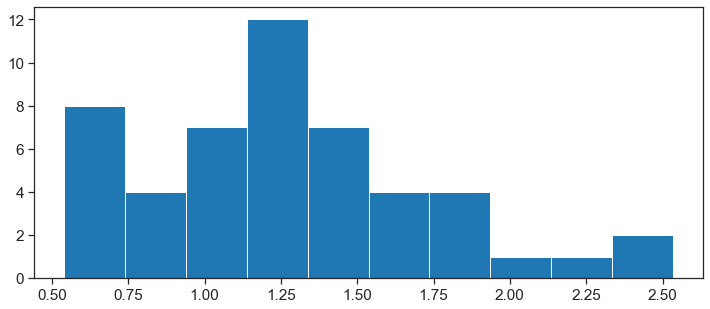

In [17]:
plt.hist(y,10)
print(min(y))
print(max(y))

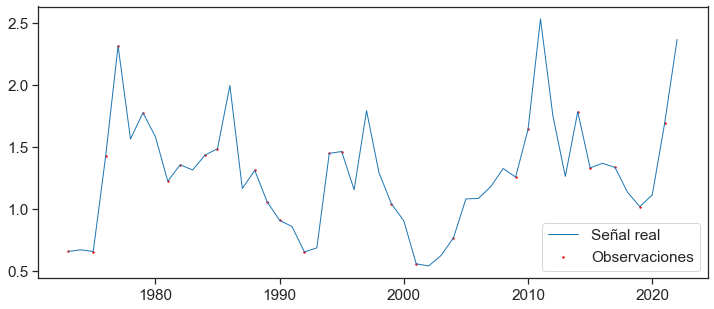

In [18]:
# Plot observations
plt.plot(t, y, label='Señal real', lw=1)
plt.scatter(t_obs, y_obs, c='r', s = 2, label='Observaciones')
plt.legend()
plt.show()

## Train Function

In [19]:
def train(tgp, quantiles = 0.9, nsamples = 10, delta = 0.5, npoints = 21):
    tgp.sample_priors()
    tgp.plot_priors(kde=True)
    learning = tg.TgLearning(tgp, lr=0.001, pbatch=0.8, rand_pert=0.0, pot=0, cycle=0.1)
    learning.execute_sgd(100)
    tgp.plot_priors(kde=True)
    return 

# Interpolation Tests

## No warping

In [20]:
def model(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ['value']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_rq = tg.TgPrior('var_rq', ['Year'], dim=dim, low=0, high=2, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=1, alpha=2, beta=4) #low = 0.0, high = 2
    freedom = tg.TgPrior('freedom', ['Year'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5 

    kernel = tg.RQ(var_rq, relevance, freedom)
    cov = tg.CovarianceTransport(kernel)

    tgp = tg.TGP([cov], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [21]:
tgp = model(coffe, train_index)

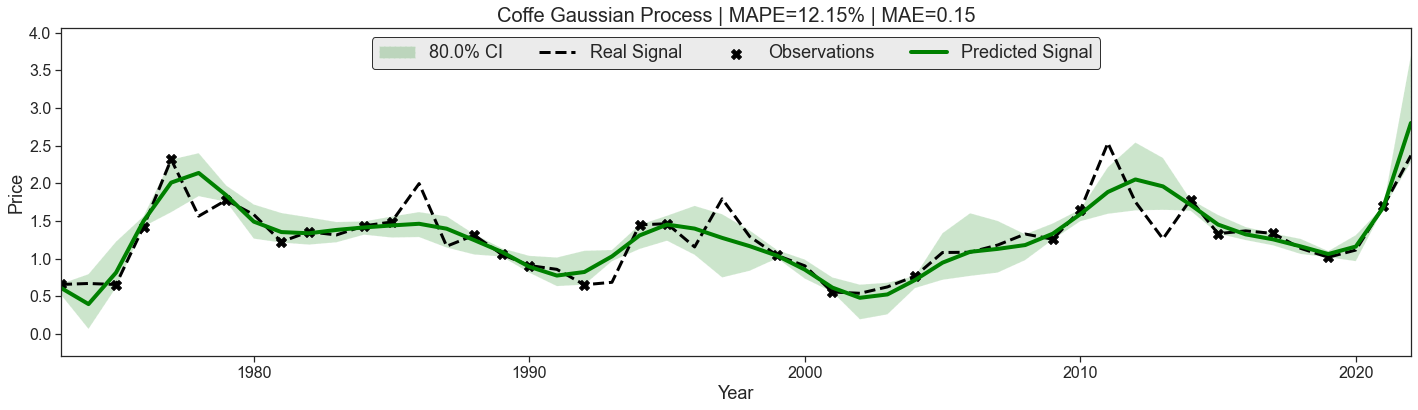

In [22]:
tgp.plot_predict('Coffe Gaussian Process', 'Year', 'Price')

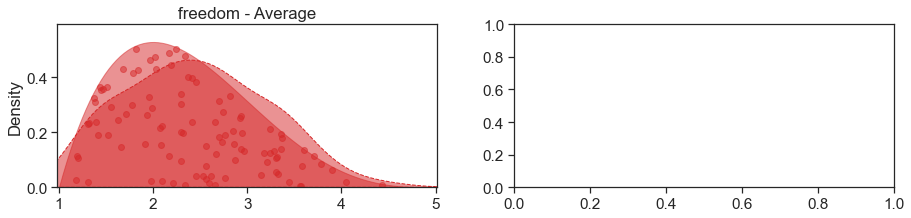

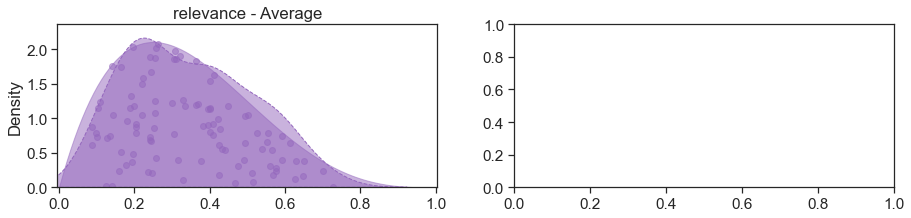

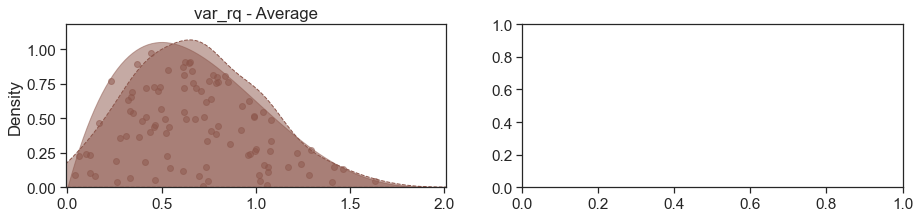

  0%|                                                                                                         …

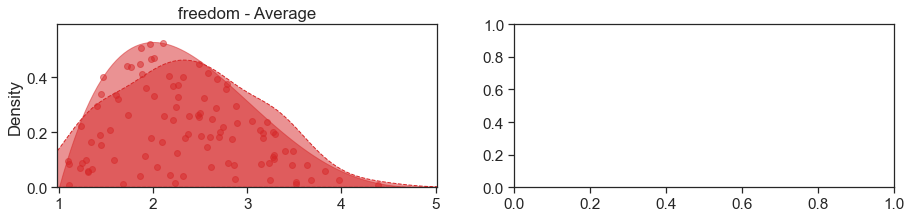

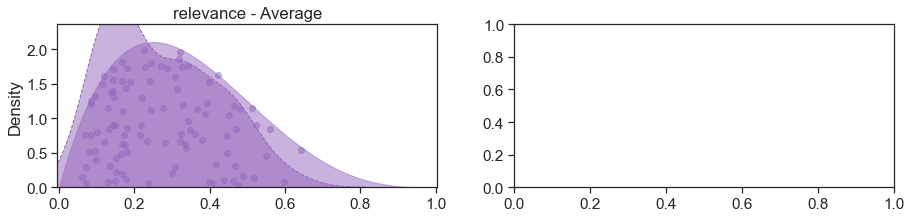

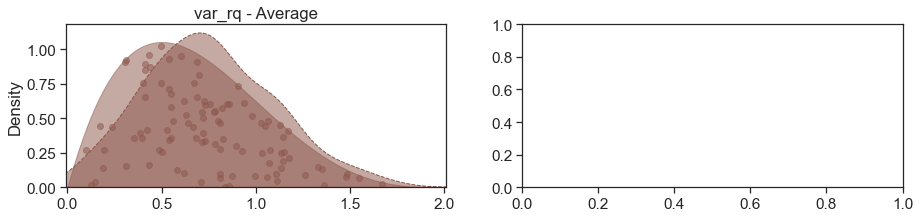

In [23]:
train(tgp)

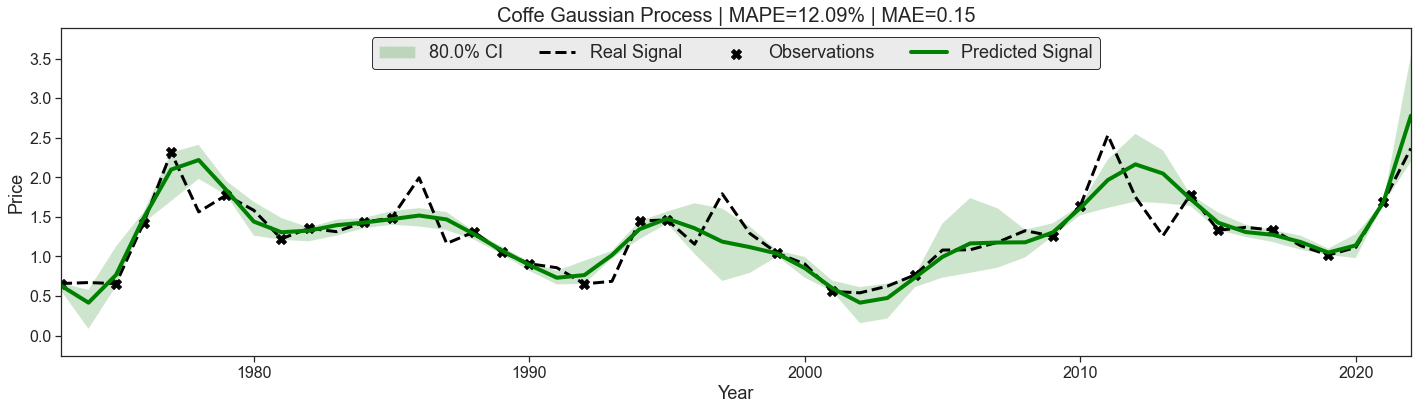

In [24]:
samples = tgp.plot_predict('Coffe Gaussian Process', 'Year', 'Price', return_samples=True)

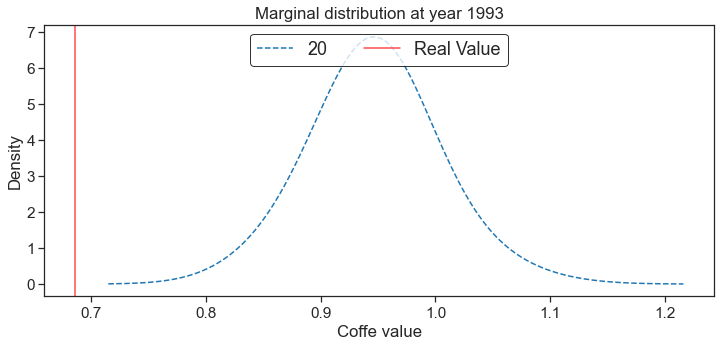

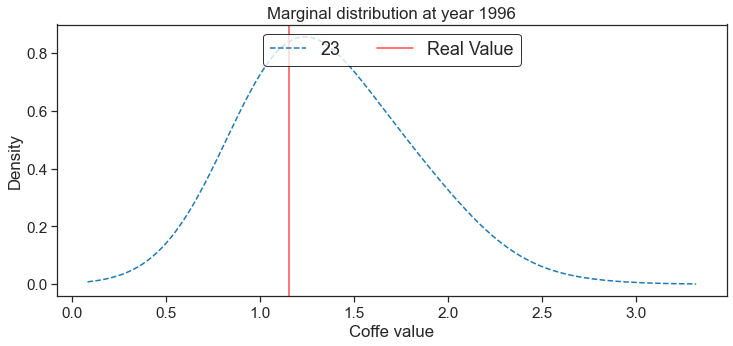

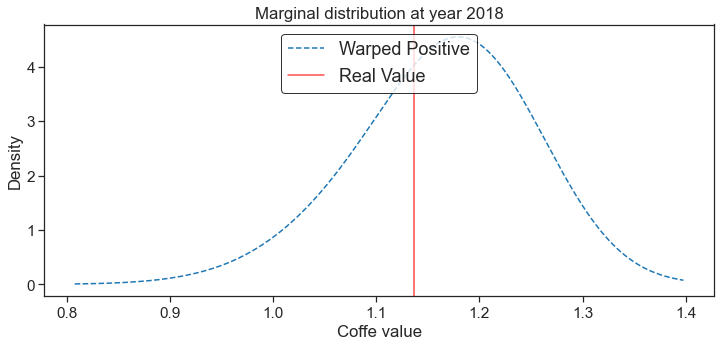

In [87]:
year = coffe['year'][20]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples[20].plot.kde(ls = '--', bw_method=1)
real = y[20]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=2, frameon=True, shadow=False, loc=9, edgecolor='k', fontsize = 18)

year = coffe['year'][23]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples[23].plot.kde(ls = '--', bw_method=1)
real = y[23]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=2, frameon=True, shadow=False, loc=9, edgecolor='k', fontsize = 18)

year = coffe['year'][45]
f2 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples[45].plot.kde(label='Warped Positive', ls = '--', bw_method=1)
real = y[45]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False, loc=9, edgecolor='k', fontsize = 18)

plt.show()

## LogShift

In [73]:
def model(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ['value']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_rq = tg.TgPrior('var_rq', ['Year'], dim=dim, low=0, high=2, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=1, alpha=2, beta=4) #low = 0.0, high = 2
    freedom = tg.TgPrior('freedom', ['Year'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5 
    noise = tg.TgPrior('noise', ['Year'], dim=dim, low=0.0, high=0.05, alpha=2, beta=4)
    shift = tg.TgPrior('shift', ['Year'], dim=dim, low=-1, high=1, alpha=2, beta=4)
    
    kernel = tg.RQ(var_rq, relevance, freedom)
    cov = tg.CovarianceTransport(kernel)
    marginal = tg.MarginalTransport(tg.LogShift(shift))
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [74]:
tgp = model(coffe, train_index)

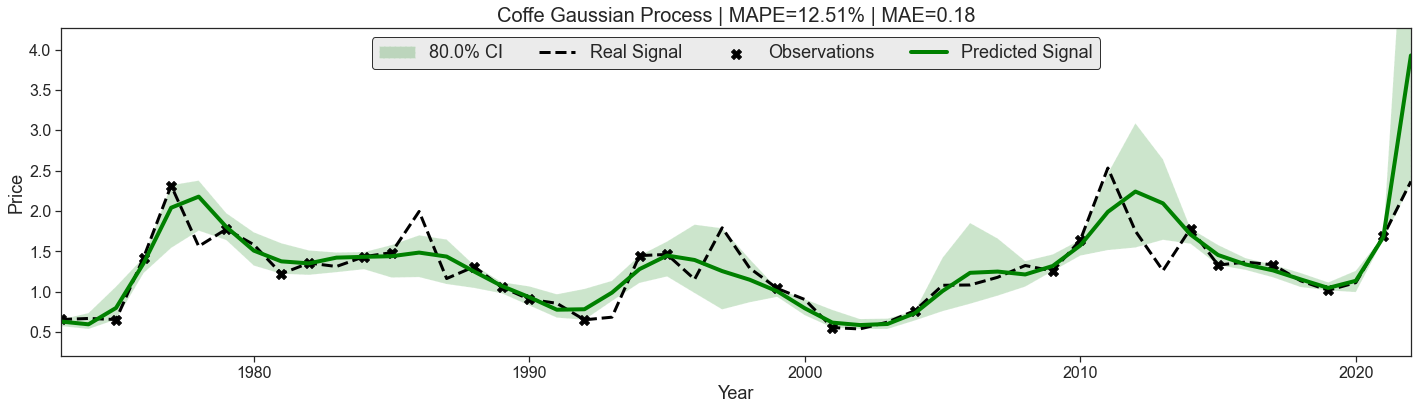

In [75]:
tgp.plot_predict('Coffe Gaussian Process', 'Year', 'Price', ylim_by_CI = False)

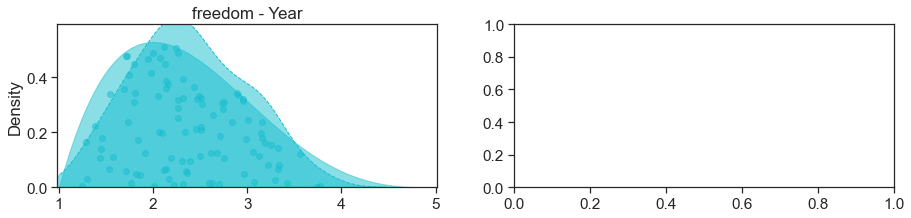

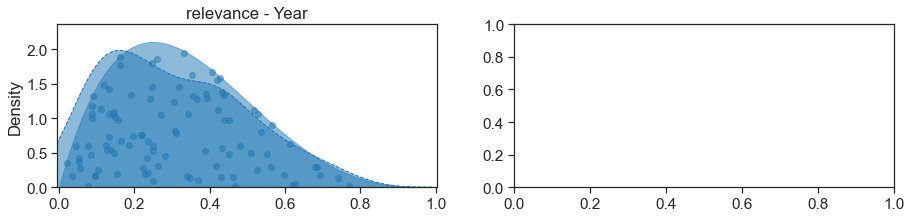

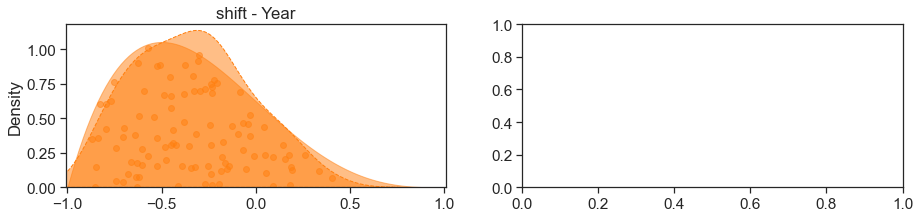

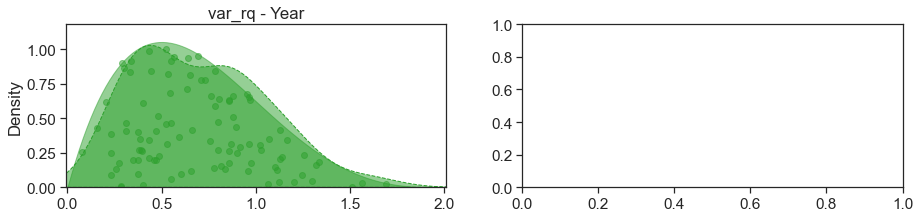

  0%|                                                                                                         …

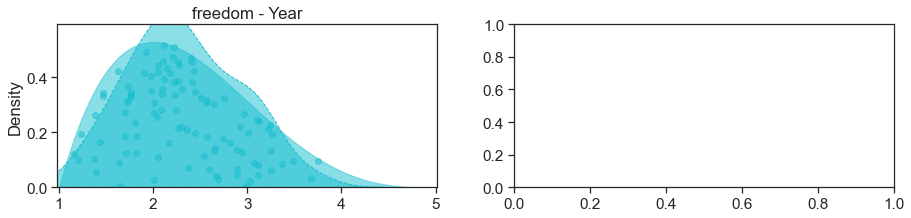

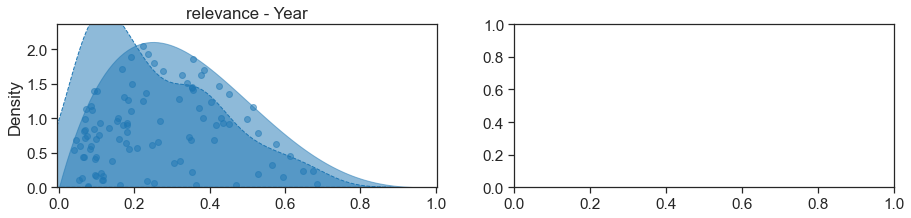

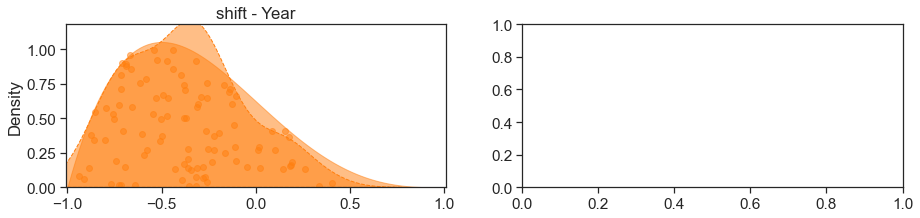

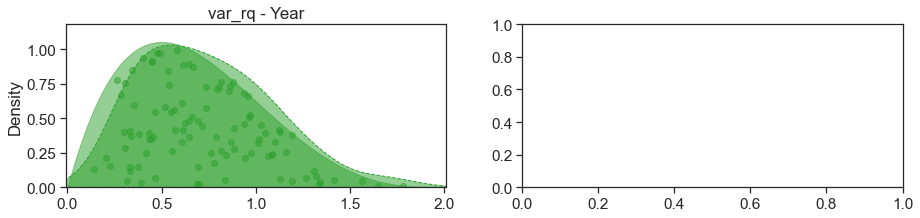

In [76]:
train(tgp)

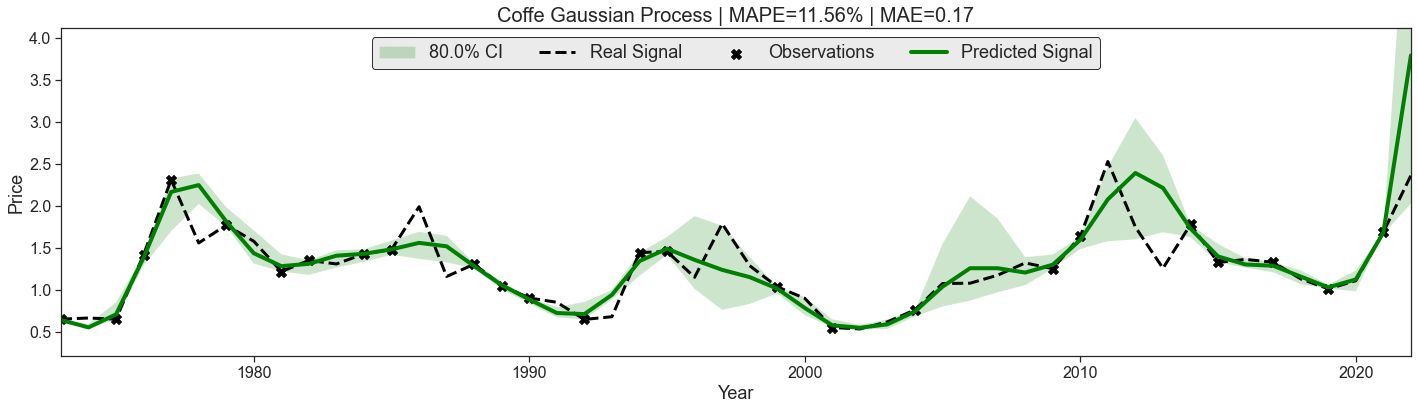

In [77]:
samples = tgp.plot_predict('Coffe Gaussian Process', 'Year', 'Price', ylim_by_CI = False, return_samples = True)

In [78]:
pred_latent, samples_latent = tgp.predict(tgp.dt.index, quantiles=0.1, median=True, mean=True, nsamples=100, samples=True, 
                            noise=False, noise_cross=False, latent=True, ntransport=1)

pred_warped, samples_warped = tgp.predict(tgp.dt.index, quantiles=0.1, median=True, mean=True, nsamples=100, samples=True, 
                            noise=False, noise_cross=False, latent=True, ntransport=2)

In [81]:
t[45]

2018

In [83]:
y[23]

1.1551751004016064

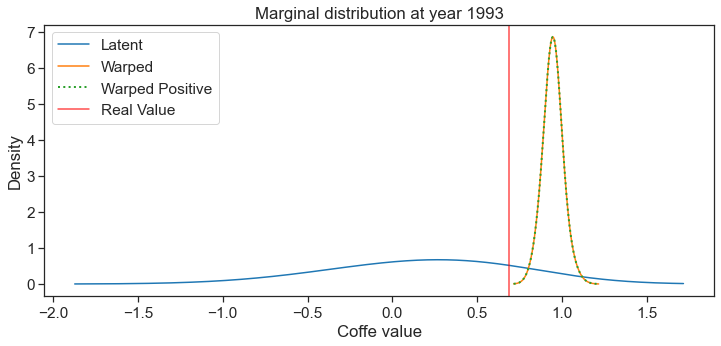

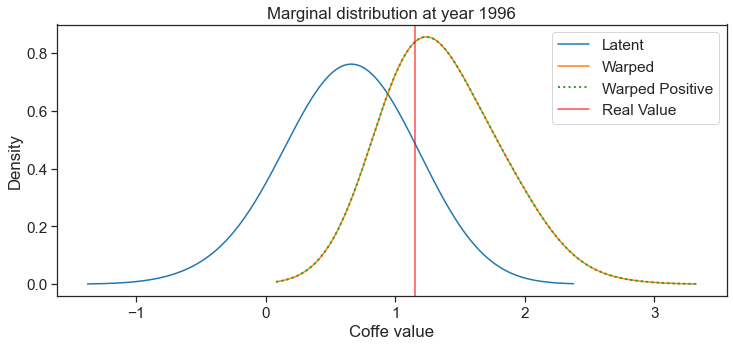

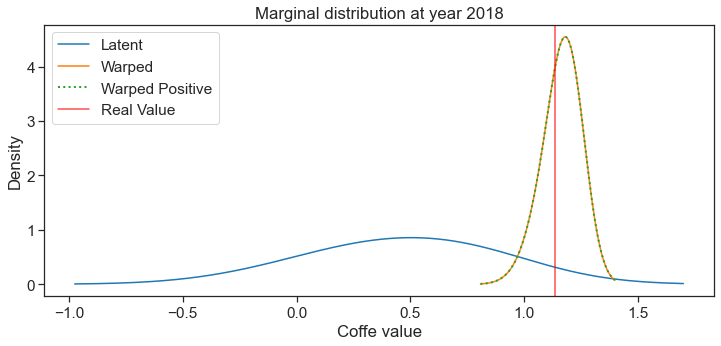

In [86]:
year = coffe['year'][20]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples_latent[20].plot.kde(label='Latent', bw_method=1)
samples_warped[20].plot.kde(label='Warped', bw_method=1)
samples[20].plot.kde(label='Warped Positive', ls = ':', lw=2, bw_method=1)
real = y[20]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False)

year = coffe['year'][23]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples_latent[23].plot.kde(label='Latent', bw_method=1)
samples_warped[23].plot.kde(label='Warped', bw_method=1)
samples[23].plot.kde(label='Warped Positive', ls = ':', lw=2, bw_method=1)
real = y[23]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False)

year = coffe['year'][45]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples_latent[45].plot.kde(label='Latent', bw_method=1)
samples_warped[45].plot.kde(label='Warped', bw_method=1)
samples[45].plot.kde(label='Warped Positive', ls = ':', lw=2, bw_method=1)
real = y[45]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False)

## BoxCoxShift

In [88]:
def model(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ['value']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_rq = tg.TgPrior('var_rq', ['Year'], dim=dim, low=0, high=2, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=1, alpha=2, beta=4) #low = 0.0, high = 2
    freedom = tg.TgPrior('freedom', ['Year'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5 
    shift = tg.TgPrior('shift', ['Year'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    power = tg.TgPrior('power', ['Year'], dim=dim, low=0, high=1.2, alpha=2, beta=4)
    
    kernel = tg.RQ(var_rq, relevance, freedom)
    cov = tg.CovarianceTransport(kernel)
    marginal = tg.MarginalTransport(tg.BoxCoxShift(power, shift))
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [89]:
tgp = model(coffe, train_index)

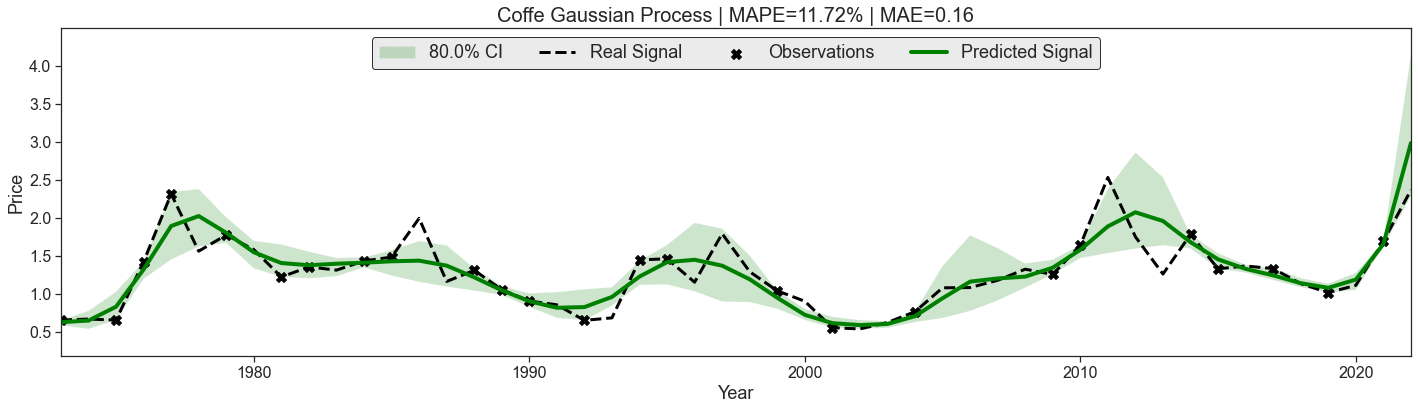

In [90]:
tgp.plot_predict('Coffe Gaussian Process', 'Year', 'Price')

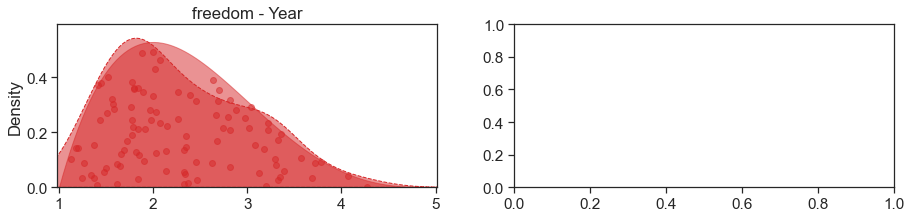

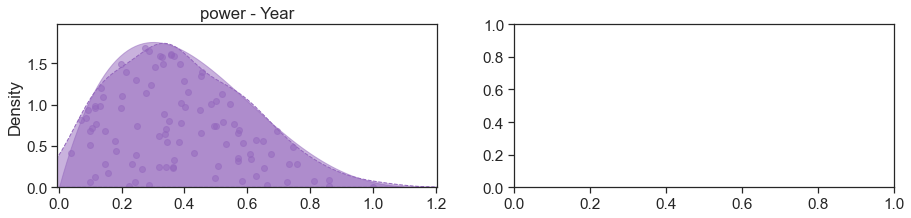

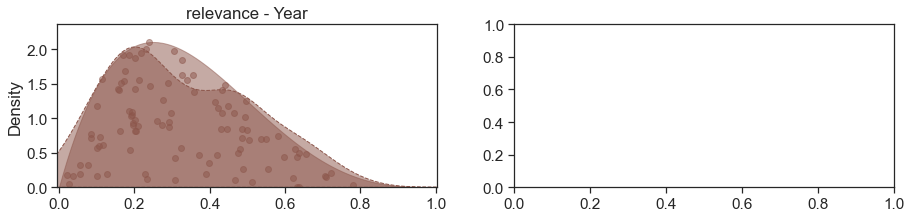

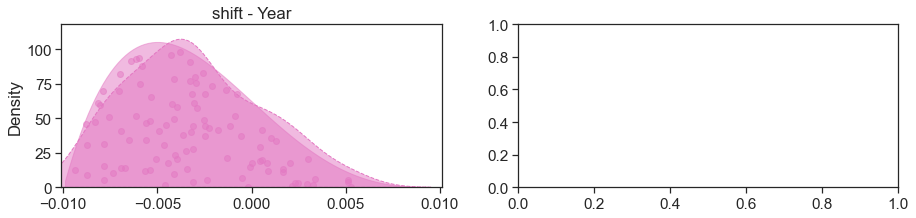

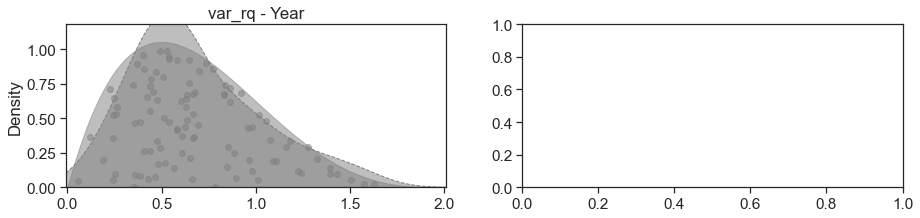

  0%|                                                                                                         …

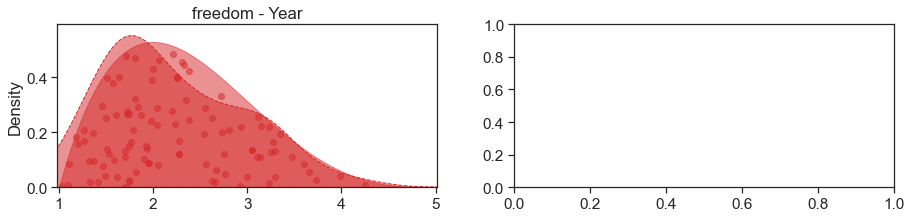

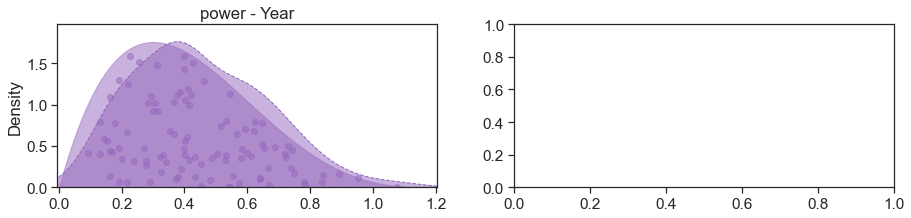

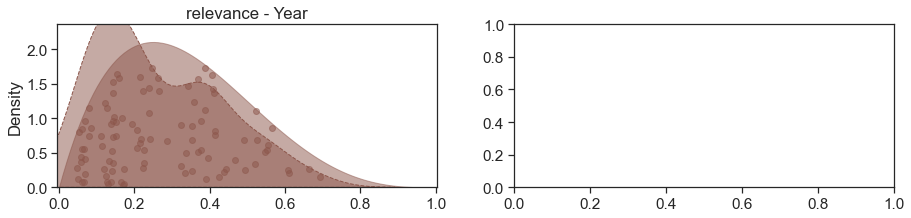

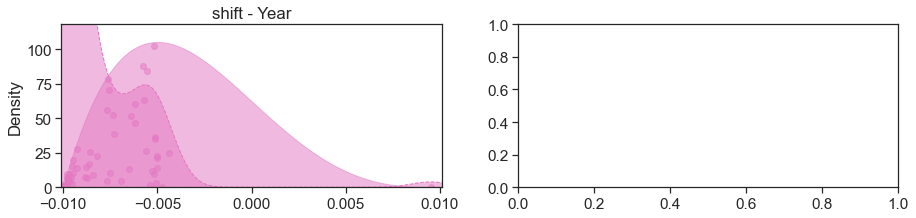

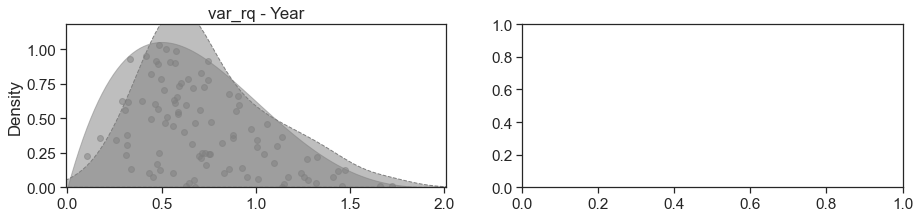

In [91]:
train(tgp)

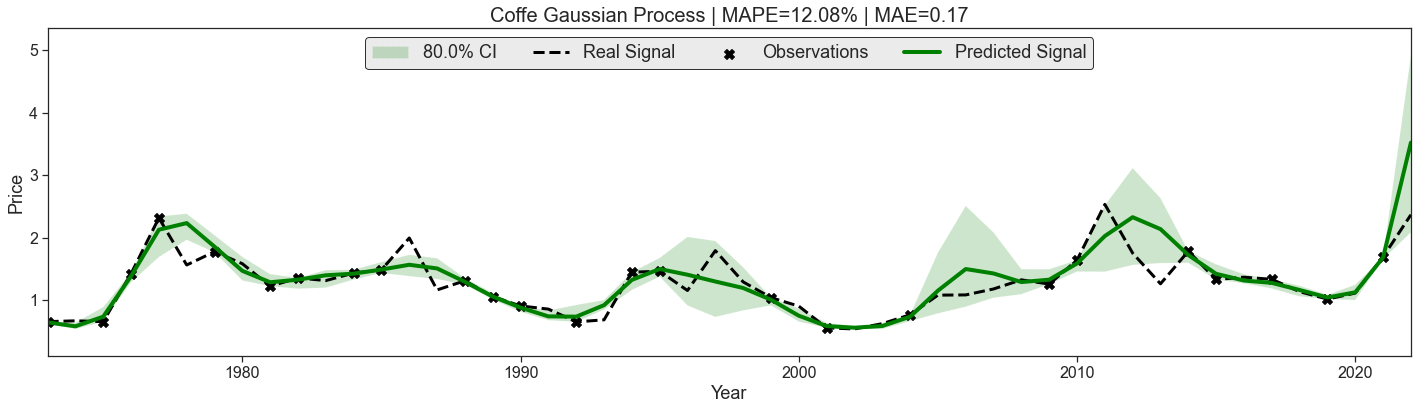

In [92]:
samples = tgp.plot_predict('Coffe Gaussian Process', 'Year', 'Price', return_samples = True)

In [93]:
pred_latent, samples_latent = tgp.predict(tgp.dt.index, quantiles=0.1, median=True, mean=True, nsamples=100, samples=True, 
                            noise=False, noise_cross=False, latent=True, ntransport=1)

pred_warped, samples_warped = tgp.predict(tgp.dt.index, quantiles=0.1, median=True, mean=True, nsamples=100, samples=True, 
                            noise=False, noise_cross=False, latent=True, ntransport=2)

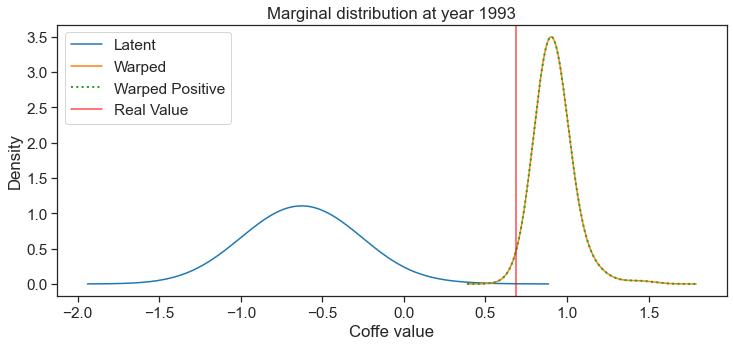

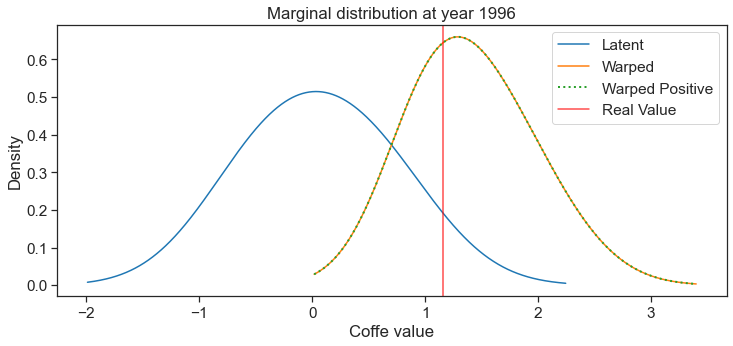

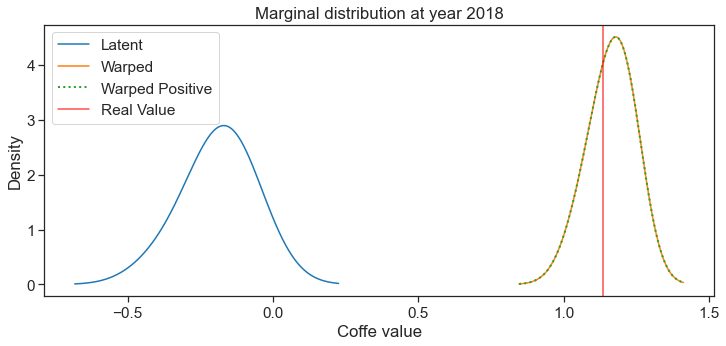

In [94]:
year = coffe['year'][20]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples_latent[20].plot.kde(label='Latent', bw_method=1)
samples_warped[20].plot.kde(label='Warped', bw_method=1)
samples[20].plot.kde(label='Warped Positive', ls = ':', lw=2, bw_method=1)
real = y[20]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False)

year = coffe['year'][23]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples_latent[23].plot.kde(label='Latent', bw_method=1)
samples_warped[23].plot.kde(label='Warped', bw_method=1)
samples[23].plot.kde(label='Warped Positive', ls = ':', lw=2, bw_method=1)
real = y[23]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False)

year = coffe['year'][45]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples_latent[45].plot.kde(label='Latent', bw_method=1)
samples_warped[45].plot.kde(label='Warped', bw_method=1)
samples[45].plot.kde(label='Warped Positive', ls = ':', lw=2, bw_method=1)
real = y[45]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False)

## Affine

In [95]:
def model(df, index_obs, dim = 100): 
    inputs = ['year']
    outputs = ['value']
    dt = tg.DataTensor(df[inputs + outputs], inputs=inputs, outputs=outputs)

    var_rq = tg.TgPrior('var_rq', ['Year'], dim=dim, low=0, high=2, alpha=2, beta=4)
    relevance = tg.TgPrior('relevance', ['Year'], dim=dim, low=0.0, high=1, alpha=2, beta=4) #low = 0.0, high = 2
    freedom = tg.TgPrior('freedom', ['Year'], dim=dim, low=1, high=5, alpha=2, beta=4) #low = 1, high = 5 
    shift = tg.TgPrior('shift', ['Year'], dim=dim, low=-0.01, high=0.01, alpha=2, beta=4)
    scale = tg.TgPrior('scale', ['Year'], dim=dim, low=0, high=1, alpha=2, beta=4)
    
    kernel = tg.RQ(var_rq, relevance, freedom)
    cov = tg.CovarianceTransport(kernel)
    marginal = tg.MarginalTransport(tg.Affine(shift, scale))
    positive = tg.MarginalTransport(tg.Relu())
    
    tgp = tg.TGP([cov, marginal, positive], dt=dt)
    tgp.obs(index_obs)
    return tgp

In [96]:
tgp = model(coffe, train_index)

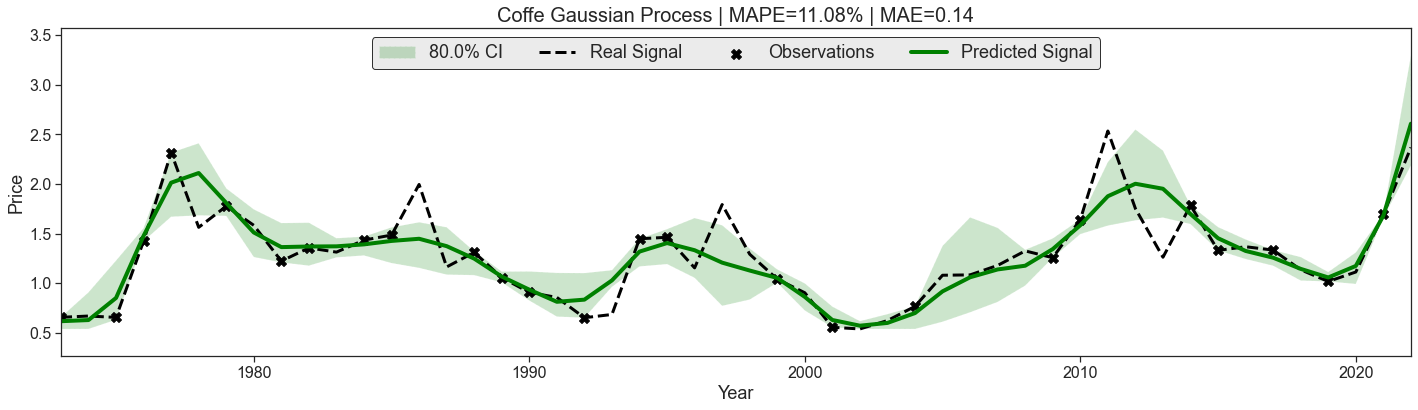

In [97]:
tgp.plot_predict('Coffe Gaussian Process', 'Year', 'Price')

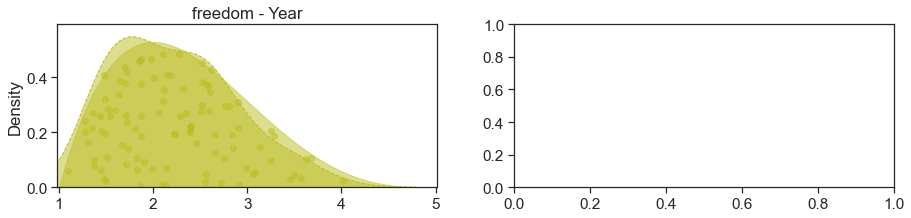

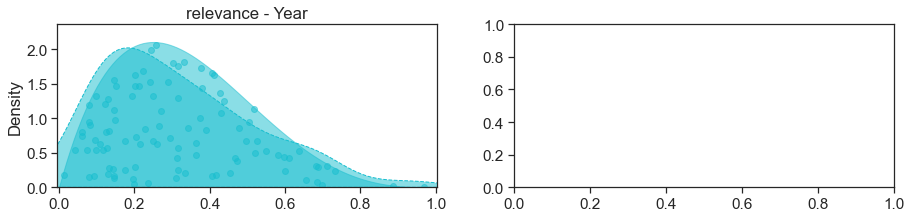

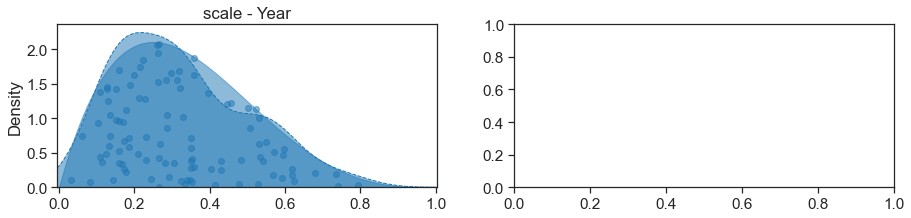

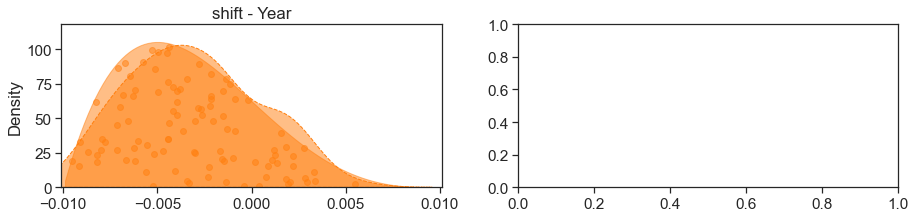

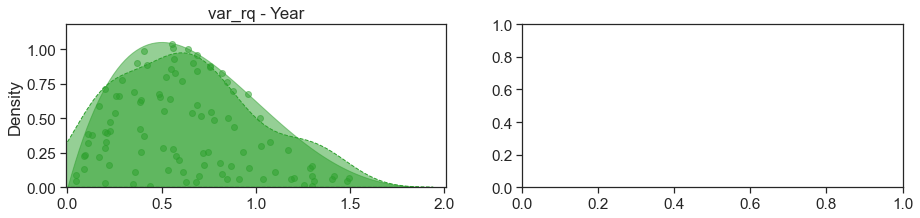

  0%|                                                                                                         …

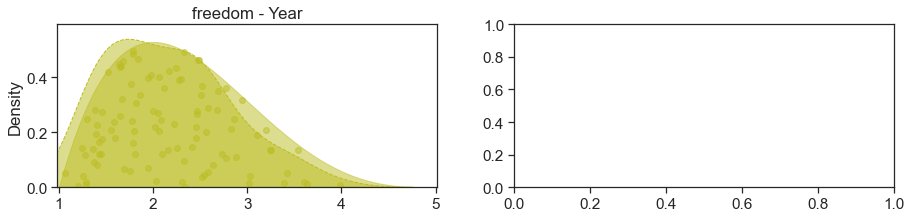

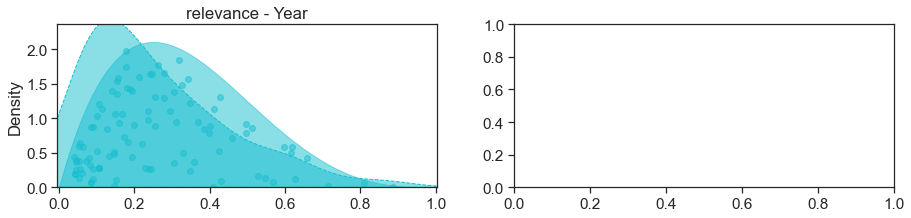

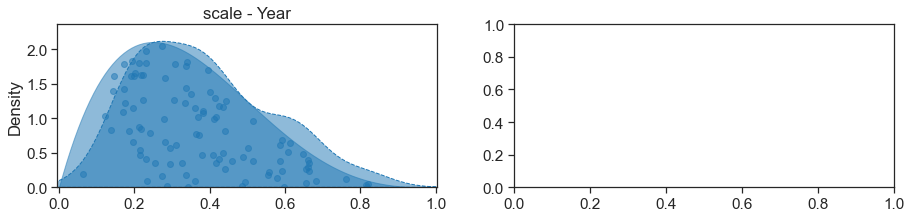

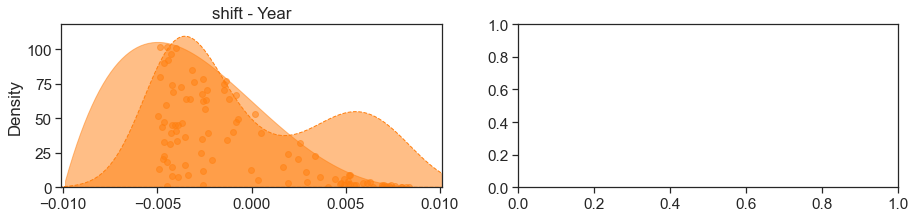

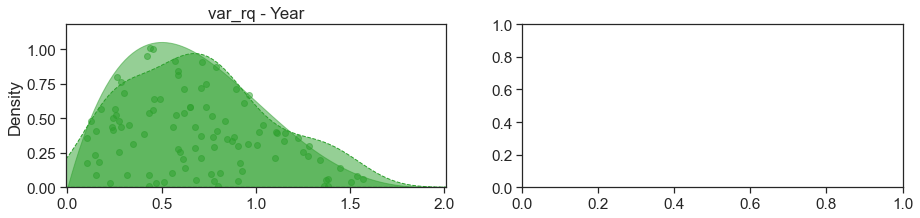

In [98]:
train(tgp)

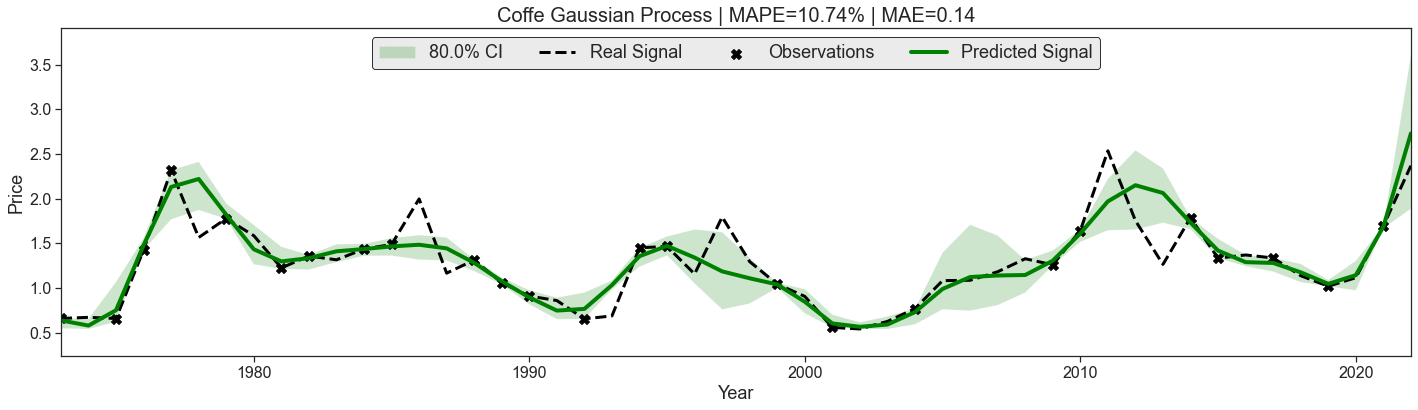

In [67]:
samples = tgp.plot_predict('Coffe Gaussian Process', 'Year', 'Price', return_samples=True)

In [99]:
pred_latent, samples_latent = tgp.predict(tgp.dt.index, quantiles=0.1, median=True, mean=True, nsamples=100, samples=True, 
                            noise=False, noise_cross=False, latent=True, ntransport=1)

pred_warped, samples_warped = tgp.predict(tgp.dt.index, quantiles=0.1, median=True, mean=True, nsamples=100, samples=True, 
                            noise=False, noise_cross=False, latent=True, ntransport=2)

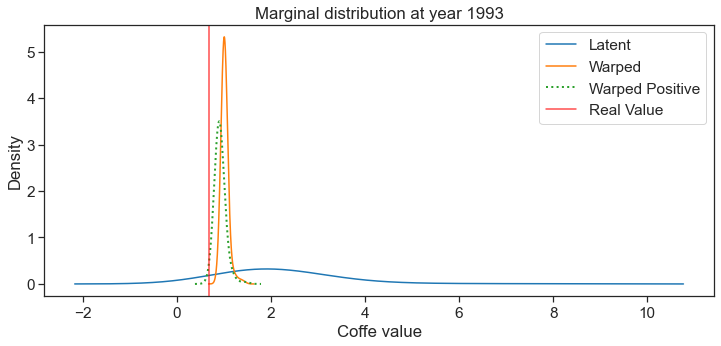

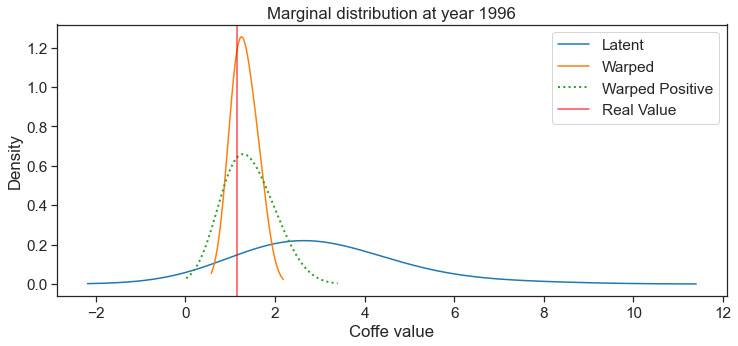

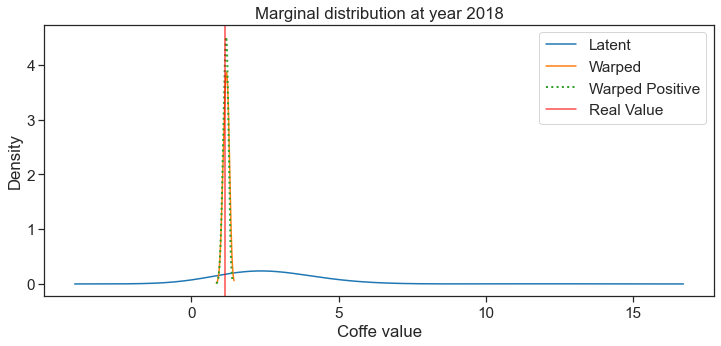

In [100]:
year = coffe['year'][20]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples_latent[20].plot.kde(label='Latent', bw_method=1)
samples_warped[20].plot.kde(label='Warped', bw_method=1)
samples[20].plot.kde(label='Warped Positive', ls = ':', lw=2, bw_method=1)
real = y[20]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False)

year = coffe['year'][23]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples_latent[23].plot.kde(label='Latent', bw_method=1)
samples_warped[23].plot.kde(label='Warped', bw_method=1)
samples[23].plot.kde(label='Warped Positive', ls = ':', lw=2, bw_method=1)
real = y[23]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False)

year = coffe['year'][45]
f1 = plt.figure()
plt.xlabel('Coffe value')
plt.ylabel('Density')
plt.title('Marginal distribution at year ' + str(year))
samples_latent[45].plot.kde(label='Latent', bw_method=1)
samples_warped[45].plot.kde(label='Warped', bw_method=1)
samples[45].plot.kde(label='Warped Positive', ls = ':', lw=2, bw_method=1)
real = y[45]
plt.axvline(x=real, c='r', alpha=0.7, label='Real Value')
plt.legend(ncol=1, frameon=True, shadow=False)

## Resumen

Warping |MAPE|MAE
-----|-----|----- 
No Warping|12.09%|0.15
LogShift|11.56%|0.17
BoxCoxShift|12.08%|0.17
Affine|10.74%|0.14